In [1]:
import sys
import os
from os import listdir
from os.path import isfile, join, expanduser
home = expanduser("~")
#sys.path.append(join(home,'Projects/helpfullscripts/'))
sys.path.append(join(home,'Projects/'))
sys.path.append('./python_files/')
#sys.path.append(home)
#sys.path.append('../')
#sys.path.append(r'C:\Users\Kas\Documents\GitHub')
#sys.path.append(r'C:\Users\Kas\Documents\GitHub\XRR_workflows\calculate_n_k_from_xrr')
import matrixmethod.mm_numba as mm
import numpy as np
import matplotlib.pyplot as plt
import xray_compounds as xc
import pandas as pd
import pint
unit = pint.UnitRegistry()
import scipy


In [2]:
#Do convert eV to nm
c = scipy.constants.c #speed of light
h = scipy.constants.h #Planck
e = scipy.constants.e #elemetry charge
hc = h*c/e*1e9 #wavelenght in nm
print(hc)
def eVnm_converter(value):
    #Planck's constant (6.6261 x 10-34 J*s) and c is the speed of light (2.9979 x 108 m/s)
    return hc/value

1239.8419843320025


In [11]:
energy_uni = np.linspace(250,300,3)
theta_uni = np.linspace(0.1,20,50)
aoi = np.deg2rad(theta_uni)
layer = np.array([10,50,1])
rough = np.array([0.1,5,1,1])
nk_sub = np.conjugate(xc.refractive_index('Si',energy_uni* unit.eV,density=2.33))
nk_sub_oxid = np.conjugate(xc.refractive_index('SiO2',energy_uni* unit.eV,density=2.1))
nk_layer1 = np.conjugate(xc.refractive_index('SiO4C8H20',energy_uni* unit.eV,density=1.8))
nk_layer2 = np.conjugate(xc.refractive_index('C8H6O',energy_uni* unit.eV,density=2.5))
for i,E in enumerate(energy_uni):
    n_stack = np.array([1 + 0 * 1j,
                        nk_layer1[i],
                        nk_layer2[i],
                        nk_sub_oxid[i],
                        nk_sub[i]])
    wl = eVnm_converter(E)
    rm, tm = mm.reflec_and_trans(n_stack, wl, aoi, layer, rough, pol=1)
    rm = np.square(np.abs(np.asarray(rm)))

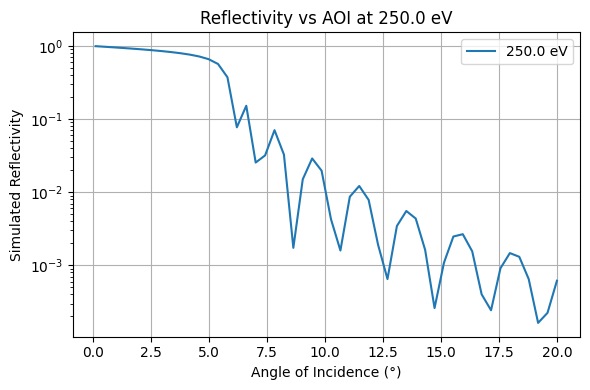

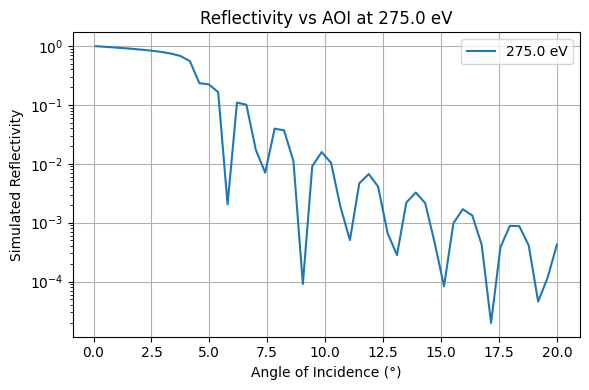

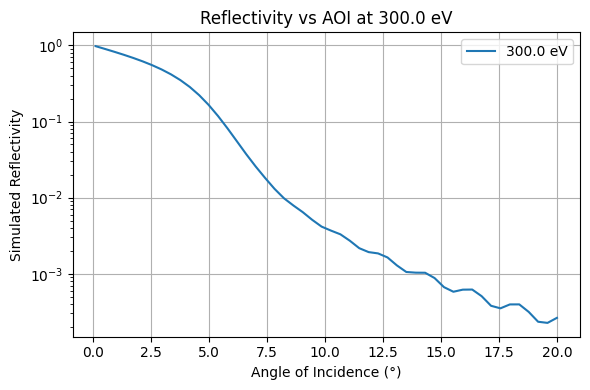

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_rm_vs_aoi(energy_uni, aoi, nk_layer1, nk_layer2, nk_sub_oxid, nk_sub, layer, rough, mm):
    #aoi_deg = np.rad2deg(aoi_rad)

    for i, E in enumerate(energy_uni):
        wl = eVnm_converter(E)
        n_stack = np.array([
            1 + 0j,
            nk_layer1[i],
            nk_layer2[i],
            nk_sub_oxid[i],
            nk_sub[i]
        ])

        rm, _ = mm.reflec_and_trans(n_stack, wl, np.deg2rad(aoi), layer, rough, pol=1)
        rm = np.square(np.abs(np.asarray(rm)))

        plt.figure(figsize=(6, 4))
        plt.plot(aoi, rm, '-', label=f'{E:.1f} eV')
        plt.xlabel('Angle of Incidence (°)')
        plt.ylabel('Simulated Reflectivity')
        plt.title(f'Reflectivity vs AOI at {E:.1f} eV')
        plt.grid(True)
        plt.legend()
        plt.yscale('log')
        plt.tight_layout()
        plt.show()

plot_rm_vs_aoi(
    energy_uni,
    theta_uni,
    nk_layer1,
    nk_layer2,
    nk_sub_oxid,
    nk_sub,
    layer,
    rough,
    mm
)


In [16]:
import pandas as pd
import numpy as np

def build_reflectivity_df(aoi_rad, energy_uni, rm_all):
    aoi_deg = np.rad2deg(aoi_rad)
    records = []

    for i, E in enumerate(energy_uni):
        rm = rm_all[i]
        for theta, R_val in zip(aoi_deg, rm):
            records.append({
                'sam_th': theta,
                'energy': E,
                'R': R_val
            })

    df = pd.DataFrame(records)
    return df

rm_all = []  # list of rm arrays per energy

for i, E in enumerate(energy_uni):
    wl = eVnm_converter(E)
    n_stack = np.array([
        1 + 0j,
        nk_layer1[i],
        nk_layer2[i],
        nk_sub_oxid[i],
        nk_sub[i]
    ])
    rm, _ = mm.reflec_and_trans(n_stack, wl, aoi, layer, rough, pol=1)
    rm = np.square(np.abs(np.asarray(rm)))
    rm_all.append(rm)

df_reflectivity = build_reflectivity_df(aoi, energy_uni, rm_all)
df_reflectivity.to_csv('./data/simulated_reflectivity.csv', index=False)